In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
import scipy.signal as signal
from scipy import sparse
from scipy.sparse.linalg import spsolve

/home/apk/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [149]:
eeg=h5py.File("ME_2_R_2019.01.04_12.46.47.hdf5",mode='r')
sampletime = np.array(eeg['AsynchronData']["Time"])
samples=np.array(eeg["RawData"]['Samples'])
samples=samples.T
sampletime1=[]
print sampletime
sampletime1=np.delete(sampletime, len(sampletime)-1)
sampletime1=np.delete(sampletime1, 0)
#sampletime1=np.delete(sampletime1, 0)
#sampletime1=sampletime
print sampletime1

[[ 8461]
 [ 8986]
 [11476]
 [13931]
 [16031]
 [18081]
 [20076]]
[ 8986 11476 13931 16031 18081]


In [123]:
def CAR(samples):
    s=[]
    for i in range(0, len(samples)):
        s.append((sum(samples))/64.0)
    
    sample=samples-s
    return sample, s

In [150]:
samples, s=CAR(samples)

In [89]:
def elliptic_bandpass(order, rp, rs, lowcut, highcut):
    fs=256
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.ellip(order, rp, rs, [low, high], btype='bandpass', analog=False, output='ba')
    return b, a

In [151]:
alpha=[]
beta=[]
gamma=[]
delta=[]
theta=[]
freq=[[0.5, 4], [4, 8], [8, 11], [15, 30], [30, 100]]
fs=256
order=4
rp=0.5
rs=30
for i in range (0, len(samples)):
    b, a = elliptic_bandpass(order, rp, rs, freq[0][0], freq[0][1])
    delta.append(signal.filtfilt(b, a, samples[i], padlen=0))
    b, a = elliptic_bandpass(order, rp, rs, freq[1][0], freq[1][1])
    theta.append(signal.filtfilt(b, a, samples[i], padlen=0))
    b, a = elliptic_bandpass(order, rp, rs, freq[2][0], freq[2][1])
    alpha.append(signal.filtfilt(b, a, samples[i], padlen=0))
    b, a = elliptic_bandpass(order, rp, rs, freq[3][0], freq[3][1])
    beta.append(signal.filtfilt(b, a, samples[i], padlen=0))
    b, a = elliptic_bandpass(order, rp, rs, freq[4][0], freq[4][1])
    gamma.append(signal.filtfilt(b, a, samples[i], padlen=0))

In [126]:
spr_channels=[0,2,7,9,11,13,15,62,25,27,29,31,33,63,43,45,47,49,51,57,59]
spr_channel_names=['fp1','fp2','f7','f3','fz','f4','f8','A1','T3','C3','Cz','C4','T4','A2','T5','P3','Pz','P4','T6'
                  ,'O1','O2']

In [153]:
epoch_alpha=[]
epoch_beta=[]
epoch_gamma=[]
epoch_delta=[]
epoch_theta=[]
n=2.0
m=6.0
for i in spr_channels:
    a=[]
    b=[]
    g=[]
    d=[]
    t=[]
    for j in sampletime1:
        a.append(alpha[i][j-int(n)*256: j+int(m)*256])
        b.append(beta[i][j-int(n)*256: j+int(m)*256])
        g.append(gamma[i][j-int(n)*256: j+int(m)*256])
        d.append(delta[i][j-int(n)*256: j+int(m)*256])
        t.append(theta[i][j-int(n)*256: j+int(m)*256])
    epoch_alpha.append(a)
    epoch_beta.append(b)
    epoch_gamma.append(g)
    epoch_delta.append(d)
    epoch_theta.append(t)
    


In [93]:
from scipy import sparse
from scipy.sparse.linalg import spsolve
def baseline_als(y, lam, p, niter=10):
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    #D = sparse.csc_matrix(np.diff(np.eye(L), 2))
    w = np.ones(L)
    for i in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

In [154]:

for i in range(0, len(epoch_beta[9])):
    z= baseline_als(epoch_beta[9][i], 10**4, 0.01, 10)
    epoch_beta[9][i]=epoch_beta[9][i]-z
erp_beta=sum(epoch_beta[10])/len(epoch_beta[9])
for i in range(0, len(epoch_beta[9])):
    epoch_beta[9][i]=epoch_beta[9][i]-erp_beta
    epoch_beta[9][i]=epoch_beta[9][i]**2

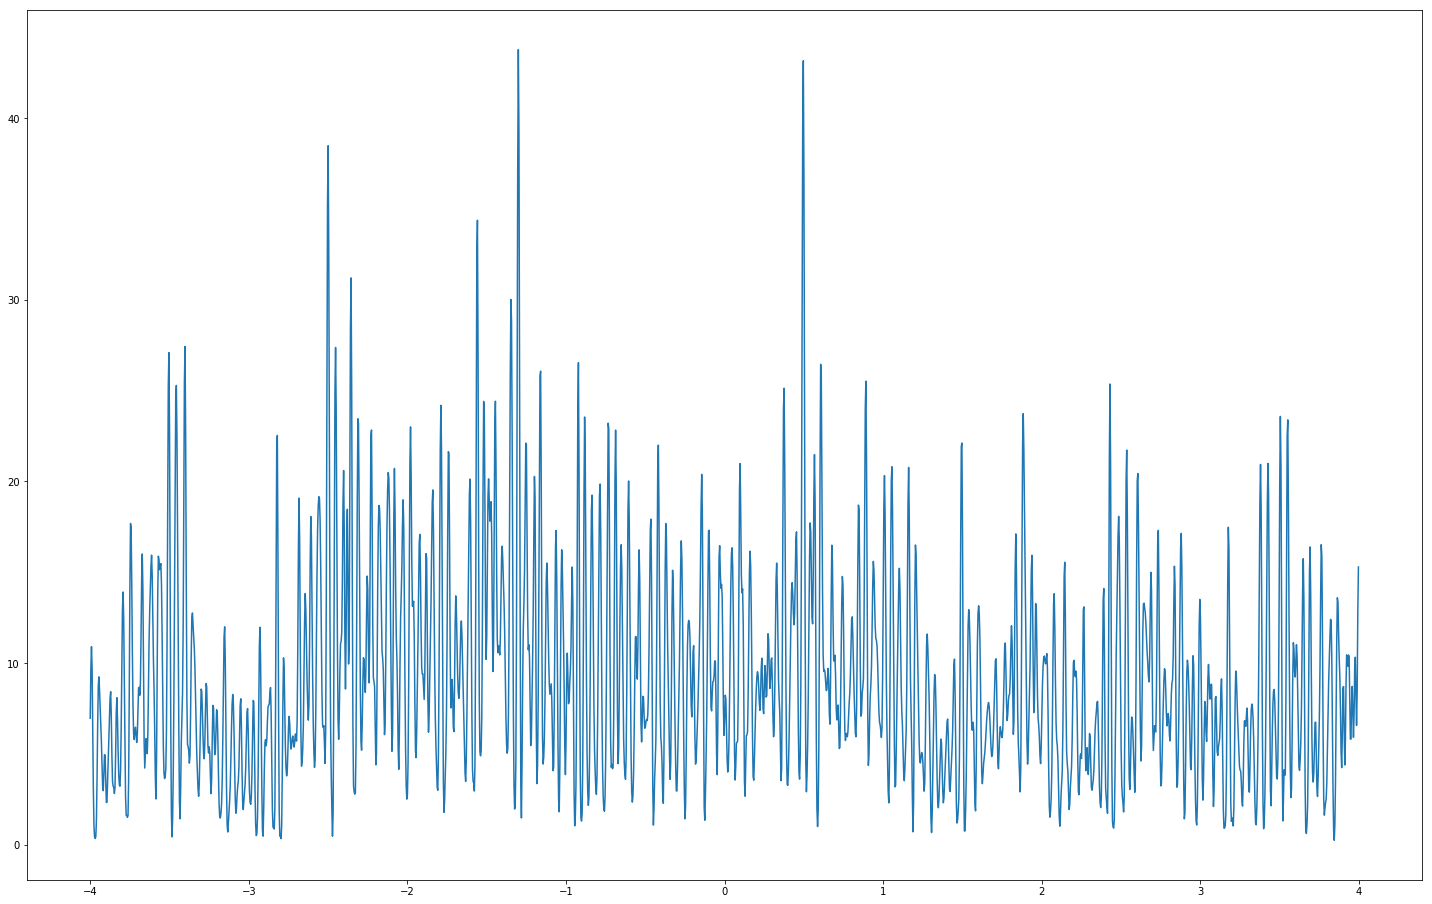

In [155]:
#erd_alpha=sum(epoch_alpha[4])/len(epoch_alpha[4])
ers_beta=sum(epoch_beta[9])/len(epoch_beta[9])
#erd_alpha=erd_aplha**2
plt.rcParams["figure.figsize"] = [25,16]
plt.plot(np.arange(-4.0, 4.0, 1/256.0), ers_beta)

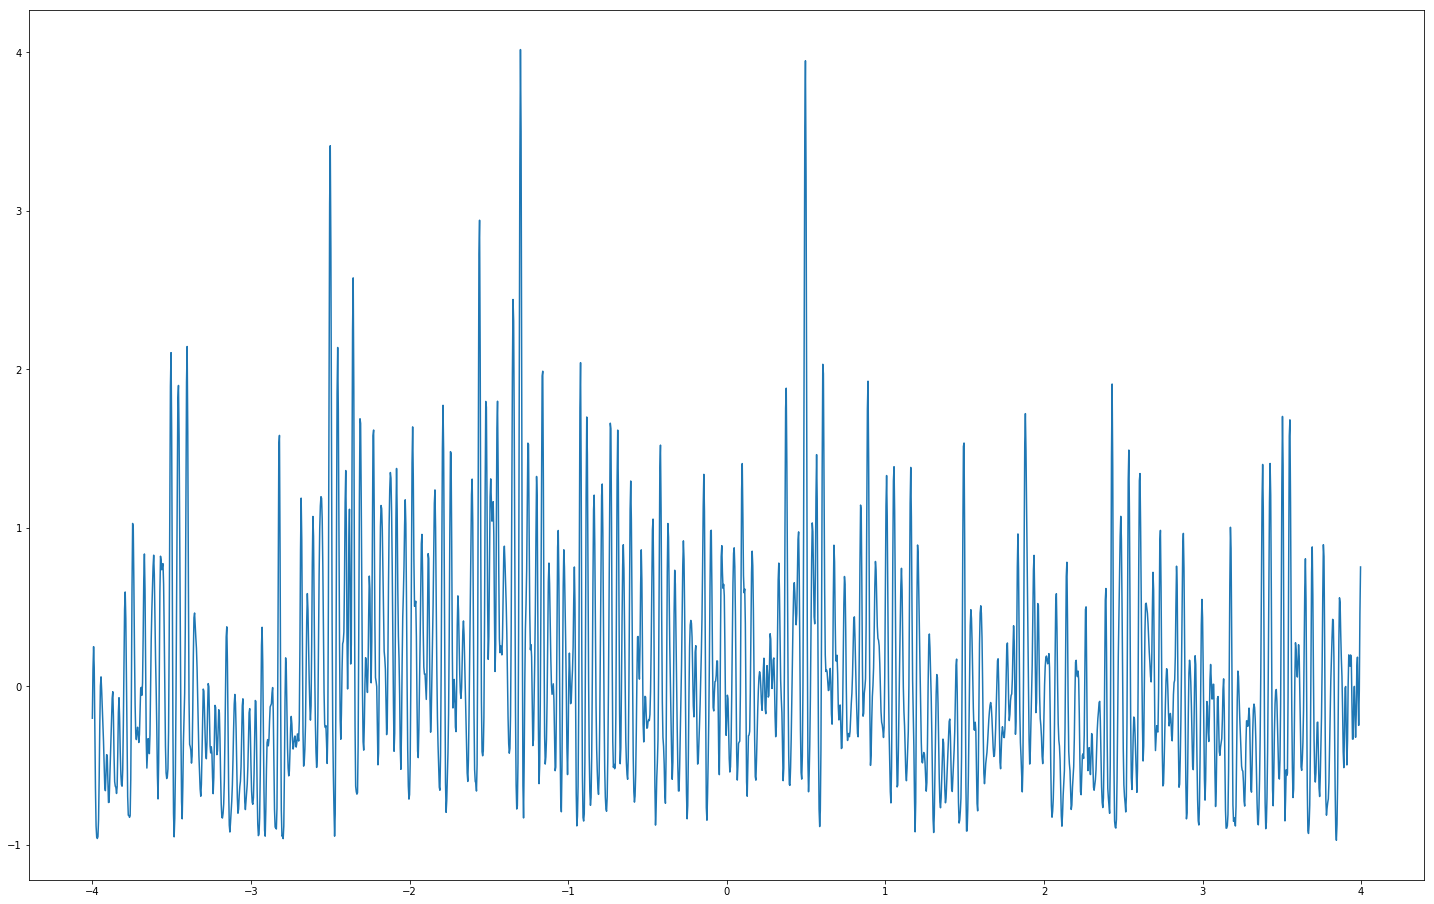

In [156]:
base=beta[27][int(sampletime[0])-256*5:int(sampletime[1])]
z1=baseline_als(base, 10**4, 0.01, 10)
base=base-z1
basepower=np.mean(base**2)
ers=(ers_beta-basepower)/basepower
plt.plot(np.arange(-4.0, 4.0, 1/256.0), ers)

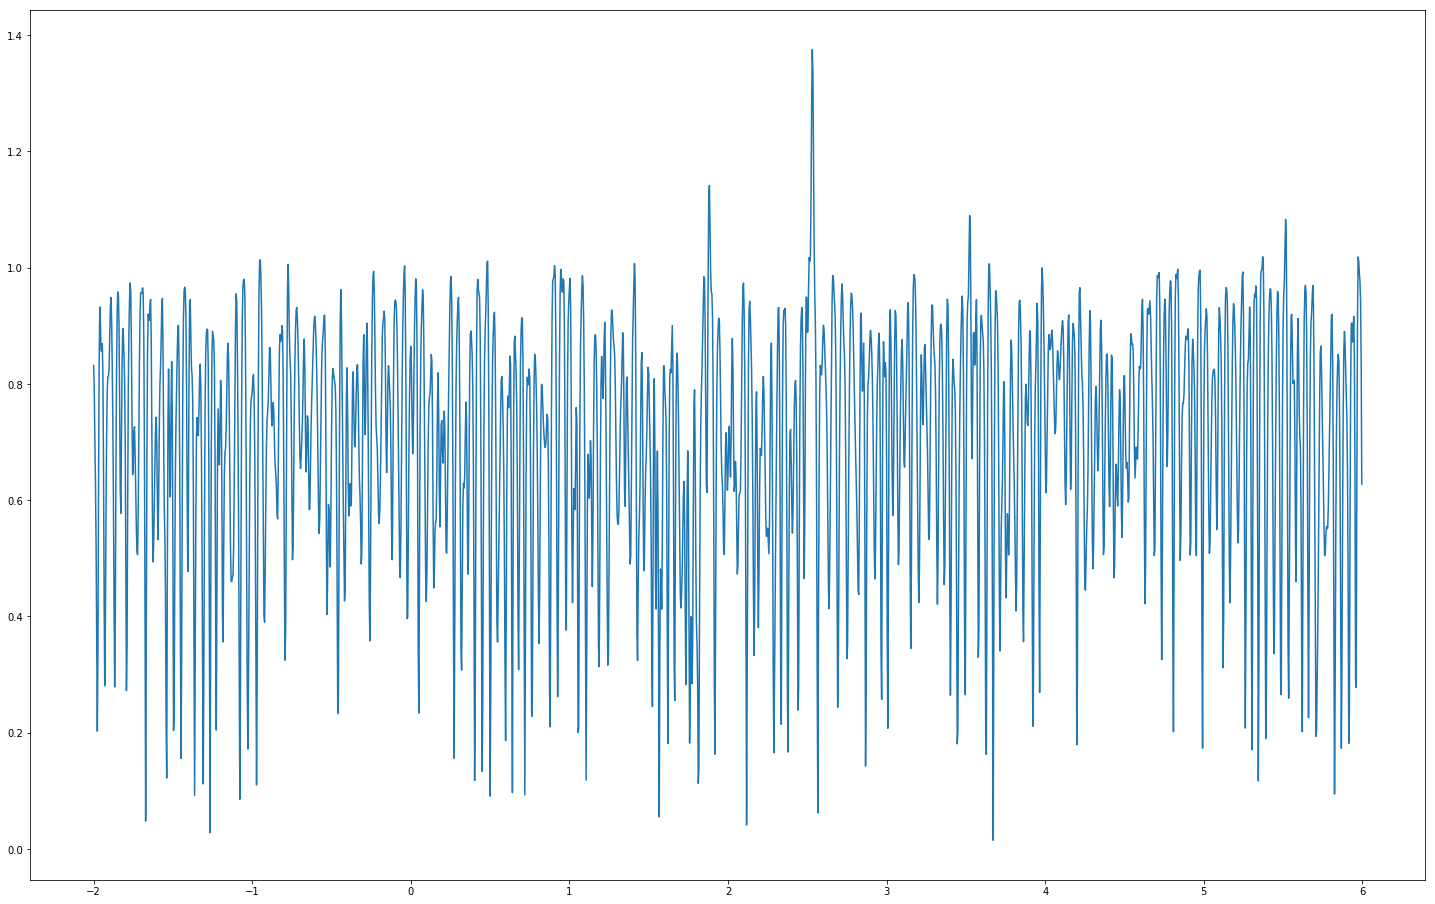

In [109]:
#from scipy import fftpack
hilbertsig=signal.hilbert(ers)
ae=np.abs(hilbertsig)
#plt.plot(np.arange(-4.0, 4.0, 1/256.0), hilbertsig.real)
#plt.plot(np.arange(-4.0, 4.0, 1/256.0), hilbertsig.imag, 'r')
plt.plot(np.arange(-2.0, 6.0, 1/256.0), ae)

1999


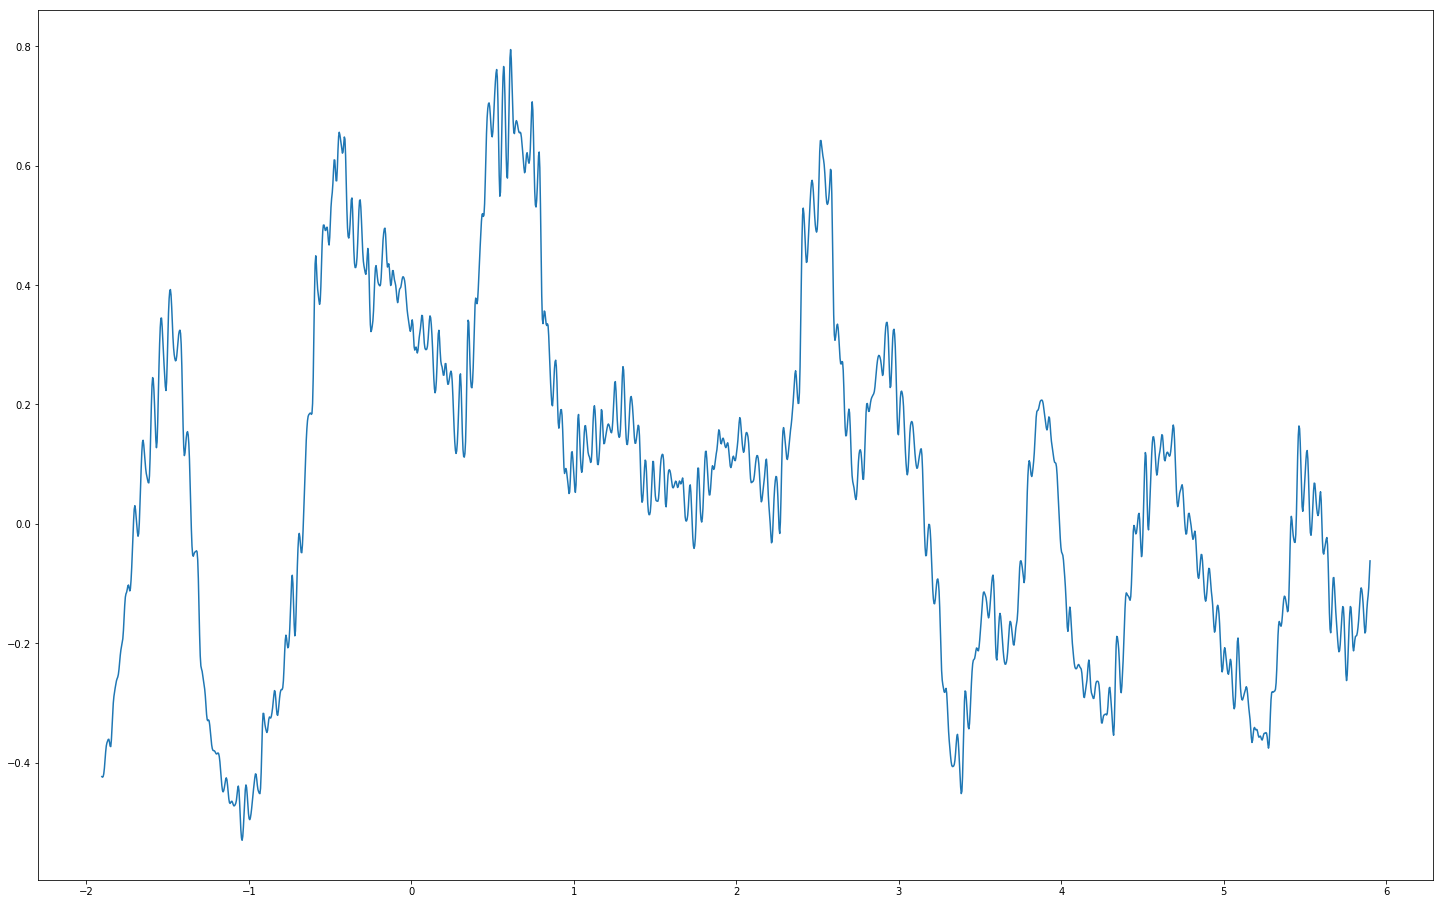

In [157]:
N=50
mov=np.convolve(ers, np.ones((N,))/N, mode='valid')
print len(mov)
plt.plot(np.arange(-len(mov)/512.0+2.0, len(mov)/512.0+2.0, 1/256.0), mov)

In [106]:
print np.arange((1024-len(mov))/256.0, (len(mov)-1024)/256.0, 1/256.0)

[-3.61328125 -3.609375   -3.60546875 ...  3.6015625   3.60546875
  3.609375  ]
